In [1]:
!pip install -qU langgraph==0.2.45 langchain-google-genai==2.0.4

In [1]:
import os
import json
import requests
from typing import List, Dict, Any, TypedDict, Annotated
from typing_extensions import TypedDict


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document
from langchain_core.prompts import PromptTemplate

from langgraph.graph import StateGraph, END, START
# from langgraph.prebuilt import ToolExecutor, tools
from langgraph.checkpoint.memory import MemorySaver
from sentence_transformers import SentenceTransformer, util

In [2]:
import dotenv
dotenv.load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")
GENAI_API_KEY = os.getenv("GENAI_API_KEY")
IMAGE_CAPTION_API_URL = "https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-large"

In [3]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=GENAI_API_KEY)

In [5]:
class CaptionState(TypedDict):
    image_path: str
    advanced_context: str
    basic_context: str
    category: str
    combined_context: str
    retrieved_captions: List[str]
    caption: str
    hashtags: List[str]
    final_output: str
    error: str

In [6]:
def extract_image_context(state: CaptionState) -> CaptionState:
    """Extract caption/context from an image using HuggingFace model."""
    print("Extracting image context...")
    try:
        image_path = state["image_path"]
        print("1")
        print(f"Image path: {image_path}")
        with open(image_path, "rb") as image_file:
            image_bytes = image_file.read()

        response = requests.post(
            IMAGE_CAPTION_API_URL,
            headers={"Authorization": f"Bearer {HF_TOKEN}"},
            data=image_bytes
        )

        print("2")
        if response.status_code != 200:
            state["error"] = f"Error extracting context: {response.text}"
            return state

        result = response.json()
        state["basic_context"] = " ".join(result[0]['generated_text'].split(" ")[1:])
        
        return state
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        state["error"] = f"Error processing image: {str(e)}"
        return state

In [7]:
def detect_category(state: CaptionState) -> CaptionState:
    """Detect category based on semantic similarity."""
    categories = {
        "travel": "Traveling to beautiful places, taking trips, visiting beaches, sunsets over mountains, road journeys, flight experiences, exploring new cultures, or backpacking adventures",
        "food": "Trying new dishes, gourmet meals, desserts like cake or pastries, dining out at restaurants, cooking recipes at home, drinking coffee, or exploring different cuisines",
        "fashion": "Wearing trendy clothes, outfit styling, streetwear, fashion shows, seasonal wardrobes, latest trends in clothing and accessories, or personal fashion statements",
        "fitness": "Daily gym workouts, home exercises, maintaining a healthy lifestyle, running, yoga sessions, lifting weights, staying fit or using fitness trackers",
        "technology": "Cutting-edge gadgets, AI-powered systems, robots, computer hardware, futuristic innovations, coding, tech events, or anything related to digital transformation",
        "sports": "Playing or watching football, cricket, basketball, sports events, Olympic games, fitness challenges, or athletes and tournaments",
        "nature": "Beautiful landscapes, sunrise or sunset views, forests, mountains, oceans, animals in the wild, natural scenery, or environmental topics",
        "education": "Learning new topics, studying, attending school or college, online courses, academic research, or reading books",
        "entertainment": "Watching movies, web series, concerts, music festivals, celebrities, fun shows, or social media trends"
    }

    context = state["advanced_context"]+state["basic_context"]
    input_embedding = sentence_model.encode(context, convert_to_tensor=True)

    best_category = "general"
    best_score = -1

    for category, example_text in categories.items():
        category_embedding = sentence_model.encode(example_text, convert_to_tensor=True)
        similarity = util.cos_sim(input_embedding, category_embedding).item()

        if similarity > best_score:
            best_score = similarity
            best_category = category

    state["category"] = best_category
    return state


In [8]:
def combine_contexts(state: CaptionState) -> CaptionState:
    """Merge the basic context from image with advanced context from user."""
    state["combined_context"] = f"Basic Image Content: {state['basic_context']}\nUser Context: {state['advanced_context']}"
    return state

In [9]:
def retrieve_captions(state: CaptionState) -> CaptionState:
    """Retrieve relevant captions based on context."""
    try:
        category = state["category"]
        basic_context = state["basic_context"]
        advanced_context = state["advanced_context"]

        persist_directory = f"./captions/{category}"
        os.makedirs(persist_directory, exist_ok=True)

        vs = Chroma(persist_directory=persist_directory, embedding_function=embedding_model)
        combined_query = f"{basic_context} {advanced_context}"
        results = vs.similarity_search(combined_query, k=5)

        state["retrieved_captions"] = [res.page_content for res in results]
        return state
    except Exception as e:
        state["error"] = f"Error retrieving captions: {str(e)}"
        state["retrieved_captions"] = []
        return state

In [10]:
def generate_caption(state: CaptionState) -> CaptionState:
    """Generate a culturally-aware caption based on contexts and examples."""
    try:
        combined_context = state["combined_context"]
        retrieved_captions = state["retrieved_captions"]
        category = state["category"]

        context_text = "\n".join(retrieved_captions)

        prompt = PromptTemplate(
            input_variables=["category", "context", "combined_context"],
            template="""
            You are an assistant that generates culturally-aware Instagram captions and hashtags.

            You specialize in {category} posts.

            Follow these steps:
            Step 1: Identify any culturally significant objects, elements, or symbolism in the visual and textual description.
            Step 2: Infer if any specific culture, tradition, or festival is likely related.
            Step 3: If the advanced context supports a cultural interpretation, incorporate it in the caption.
            Step 4: Generate an engaging, original Instagram caption (without hashtags) that captures the cultural or emotional essence.

            Here are some similar captions for reference:
            {context}

            Combined context from image and user:
            {combined_context}

            Respond with just the caption. Make it conversational, authentic, and attention-grabbing. Keep it under 150 characters.
            """
        )

        formatted_prompt = prompt.format(
            category=category,
            context=context_text,
            combined_context=combined_context
        )

        response = llm.invoke(formatted_prompt)
        state["caption"] = response.content.strip()
        return state
    except Exception as e:
        state["error"] = f"Error generating caption: {str(e)}"
        return state

In [11]:
def generate_hashtags(state: CaptionState) -> CaptionState:
    """Generate relevant hashtags based on caption and category."""
    try:
        caption = state["caption"]
        category = state["category"]
        retrieved_captions = state["retrieved_captions"]

        context_text = "\n".join(retrieved_captions)

        prompt = PromptTemplate(
            input_variables=["caption", "category", "context"],
            template="""
            You are a hashtag specialist for Instagram {category} posts.

            Here's the caption: {caption}

            Here are some example captions with their hashtags:
            {context}

            Generate 5-7 relevant, trending hashtags for the caption.
            Include both popular general hashtags and specific ones related to the content.
            Return only the hashtags as a comma-separated list without explanation or numbering.
            Each hashtag should start with # and have no spaces.
            """
        )

        formatted_prompt = prompt.format(
            caption=caption,
            category=category,
            context=context_text
        )

        response = llm.invoke(formatted_prompt)
        hashtags = [tag.strip() for tag in response.content.replace("\n", " ").split(",") if tag.strip()]
        state["hashtags"] = hashtags
        return state
    except Exception as e:
        state["error"] = f"Error generating hashtags: {str(e)}"
        return state

In [12]:
def assemble_output(state: CaptionState) -> CaptionState:
    """Combine caption and hashtags into final output."""
    caption = state["caption"]
    hashtags = state["hashtags"]

    hashtag_text = " ".join(hashtags)
    state["final_output"] = f"{caption}\n\n{hashtag_text}"
    return state


In [13]:
def should_retry(state: CaptionState) -> str:
    """Determine if we need to retry any step based on error."""
    if "error" in state and state["error"]:
        print(f"Error encountered: {state['error']}")
        return "retry"
    return "continue"

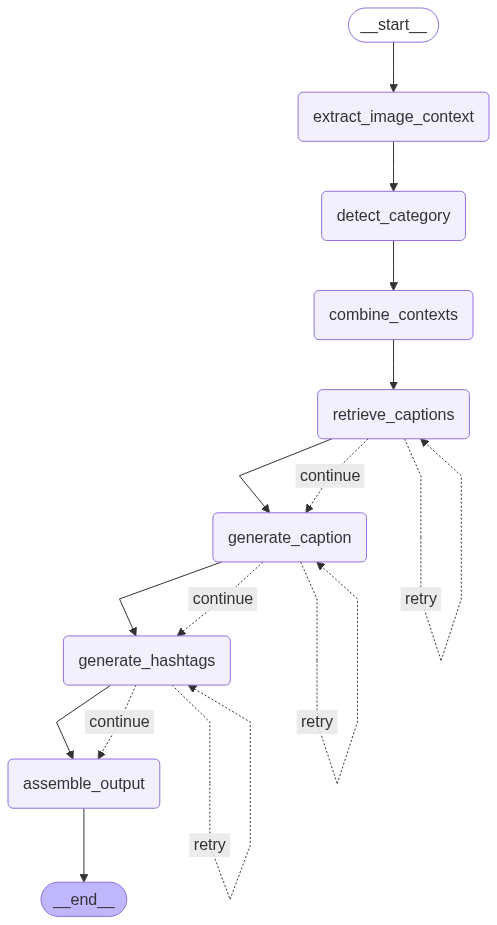

In [17]:
from IPython.display import Image


def build_instagram_caption_workflow():
    """Create and return the Instagram caption generation workflow."""
    workflow = StateGraph(CaptionState)

    workflow.add_node("extract_image_context", extract_image_context)
    workflow.add_node("detect_category", detect_category)
    workflow.add_node("combine_contexts", combine_contexts)
    workflow.add_node("retrieve_captions", retrieve_captions)
    workflow.add_node("generate_caption", generate_caption)
    workflow.add_node("generate_hashtags", generate_hashtags)
    workflow.add_node("assemble_output", assemble_output)

    workflow.add_edge(START, "extract_image_context")
    workflow.add_edge("extract_image_context", "detect_category")
    workflow.add_edge("detect_category", "combine_contexts")
    workflow.add_edge("combine_contexts", "retrieve_captions")
    workflow.add_edge("retrieve_captions", "generate_caption")
    workflow.add_edge("generate_caption", "generate_hashtags")
    workflow.add_edge("generate_hashtags", "assemble_output")
    workflow.add_edge("assemble_output", END)

    # Add conditional edges for error handling
    # workflow.add_conditional_edges(
    #     "extract_image_context",
    #     should_retry,
    #     {
    #         "retry": "extract_image_context",
    #         "continue": "detect_category"
    #     }
    # )

    workflow.add_conditional_edges(
        "retrieve_captions",
        should_retry,
        {
            "retry": "retrieve_captions",
            "continue": "generate_caption"
        }
    )

    workflow.add_conditional_edges(
        "generate_caption",
        should_retry,
        {
            "retry": "generate_caption",
            "continue": "generate_hashtags"
        }
    )

    workflow.add_conditional_edges(
        "generate_hashtags",
        should_retry,
        {
            "retry": "generate_hashtags",
            "continue": "assemble_output"
        }
        
    )

    # Optionally visualize the workflow (uncomment if needed)
    display(Image(workflow.compile().get_graph().draw_mermaid_png()))
    # return workflow.compile()

build_instagram_caption_workflow()

In [13]:
# Utility functions
def load_json_data(json_file: str) -> List[Document]:
    """Load caption data from JSON file."""
    with open(json_file, "r", encoding="utf-8") as file:
        data = json.load(file)

    documents = []
    for item in data:
        caption = item.get("caption", "")
        hashtags = " ".join(item.get("hashtags", []))
        content = f"{caption} {hashtags}"
        documents.append(Document(page_content=content))

    return documents

def update_chroma_db(category: str, json_file: str) -> None:
    """Update ChromaDB with new documents."""
    persist_directory = f"./captions/{category}"
    os.makedirs(persist_directory, exist_ok=True)

    new_documents = load_json_data(json_file)
    vs = Chroma(persist_directory=persist_directory, embedding_function=embedding_model)
    vs.add_documents(new_documents)

In [14]:
class InstagramCaptionGenerator:
    """Main class for the Instagram caption generation workflow."""

    def __init__(self):
        self.workflow = build_instagram_caption_workflow()
        self.memory = MemorySaver()

    def generate(self, image_path: str, advanced_context: str) -> Dict[str, Any]:
        """Execute the full caption generation workflow."""
        initial_state = {
            "image_path": image_path,
            "advanced_context": advanced_context,
            "basic_context": "",
            "category": "",
            "combined_context": "",
            "retrieved_captions": [],
            "caption": "",
            "hashtags": [],
            "final_output": "",
            "error": ""
        }

        result = self.workflow.invoke(initial_state)
        
        # try:
        #     display(Image(self.workflow.get_graph().draw_png()))
        # except ImportError:
        #     print(
        #         "You likely need to install dependencies for pygraphviz, see more here https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt"
        #     )


        print(f"Image Context: {result['basic_context']}")
        print(f"Detected Category: {result['category']}")
        print(result)

        return result

In [ ]:
# # Example usage to test wihtout running Flask 
# generator = InstagramCaptionGenerator()


# result = generator.generate(
#     image_path="/Users/aldrinvrodrigues/Engineering/SEM-6/Gen-AI/GenaiProject/testimage.jpeg",
#     advanced_context="Christmas 2024"
# )

# print("\n=== Generated Instagram Post ===")
# print(result["final_output"])

Extracting image context...
1
Image path: /Users/aldrinvrodrigues/Engineering/SEM-6/Gen-AI/GenaiProject/testimage.jpeg
2
Image Context: view of a beach with a lot of people on it
Detected Category: travel
{'image_path': '/Users/aldrinvrodrigues/Engineering/SEM-6/Gen-AI/GenaiProject/testimage.jpeg', 'advanced_context': 'Christmas 2024', 'basic_context': 'view of a beach with a lot of people on it', 'category': 'travel', 'combined_context': 'Basic Image Content: view of a beach with a lot of people on it\nUser Context: Christmas 2024', 'retrieved_captions': ['<ORG> Celebrating the Year of the Snake in Macao with a spectacular parade followed by dazzling fireworks display lighting up the night sky! 🐉🏮 Wishing everyone prosperity, joy, and good fortune this Lunar New Year! 🧧🎉 PaidPartnership ChineseNewYear FireworksMagic 2025macaofirework festival bali tropical#worldenvironmentday happy birthday', '<ORG> Celebrating the Year of the Snake in Macao with a spectacular parade followed by dazzl

In [18]:
# print(result)

In [19]:
# Uncomment and run to add to ChromaDB vector database
# update_chroma_db("travel", "travel.json")
# update_chroma_db("food", "food.json")
# update_chroma_db("fashion", "fashion.json")
# update_chroma_db("fitness", "fitness.json")
# update_chroma_db("technology", "technology.json")
# update_chroma_db("sports", "sports.json")

In [20]:
# !pip install flask flask_cors 

In [21]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import base64
import os
import tempfile
import threading
from flask import render_template

app = Flask(__name__)
CORS(app)  # Enable cross-origin requests

@app.route('/')
def index():
    ## start frontend.html
    return render_template('frontend.html')

@app.route('/generate-caption', methods=['POST'])
def generate_caption_api():
    data = request.json
    image_data = data.get('image')
    context = data.get('context', '')
    
    # Decode base64 image
    image_content = base64.b64decode(image_data.split(',')[1])
    
    # Save to temp file
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
    temp_file.write(image_content)
    temp_file.close()
    
    # Run your caption generator
    generator = InstagramCaptionGenerator()
    result = generator.generate(
        image_path=temp_file.name,
        advanced_context=context
    )
    
    # Clean up
    os.unlink(temp_file.name)
    
    return jsonify(result)

def run_app():
    app.run(debug=True, use_reloader=False)

threading.Thread(target=run_app).start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2025 09:55:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2025 09:55:28] "GET /apple-touch-icon-precomposed.png HTTP/1.1" 404 -
127.0.0.1 - - [22/Apr/2025 09:55:28] "GET /apple-touch-icon.png HTTP/1.1" 404 -
127.0.0.1 - - [22/Apr/2025 09:55:28] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [22/Apr/2025 09:55:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2025 09:55:44] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [22/Apr/2025 09:56:54] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmp4mazy2su.jpg
2


127.0.0.1 - - [22/Apr/2025 09:57:03] "POST /generate-caption HTTP/1.1" 200 -


Image Context: woman in a red dress lighting a small candle on a rangi
Detected Category: food
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmp4mazy2su.jpg', 'advanced_context': 'festival ', 'basic_context': 'woman in a red dress lighting a small candle on a rangi', 'category': 'food', 'combined_context': 'Basic Image Content: woman in a red dress lighting a small candle on a rangi\nUser Context: festival ', 'retrieved_captions': ['Celebrate Eid with this rich, flaky, and nutty Baklava! Layers of crisp phyllo pastry, crunchy nuts, and aromatic syrup make this a perfect festive treat ✨ Ingredients - •Phyllo Pastry Sheets - 1/2 a packet (around 18-20 sheets) •Pistachios - 50g •Walnuts - 50g •Castor Sugar - 1/3rd cup •Cinnamon powder - 1/4th teaspoon •Salt - a pinch •Butter/Ghee- 1/2 Cup •Butter for Greasing the Pan Syrup •Sugar - 1 Cup •Water - 3/4th Cup •Lemon Juice - 1 teaspoon •Rose Water - 1/2 teaspoon Process - * Preheat the oven at 180c * In a bowl mix fine chop

127.0.0.1 - - [22/Apr/2025 09:59:18] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpek3pbrvc.jpg
2


127.0.0.1 - - [22/Apr/2025 09:59:23] "POST /generate-caption HTTP/1.1" 200 -


Image Context: is a large white building with a dome on top of it
Detected Category: travel
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpek3pbrvc.jpg', 'advanced_context': 'vacation 2025', 'basic_context': 'is a large white building with a dome on top of it', 'category': 'travel', 'combined_context': 'Basic Image Content: is a large white building with a dome on top of it\nUser Context: vacation 2025', 'retrieved_captions': ['s Goa still worth it in 2025? 🌴 I walked along the beaches, soaking in the vibe, and here’s the verdict! <ORG> magic is still alive, but it comes with a price—literally. 🤑 From skyrocketing shacks to inflated cab fares, the heavy prices can hit hard. But the vibe? It’s unmatched—sunsets, music, and chilled-out energy still make it special. Would I go back? 100%! But maybe with a little extra cash and a lot of off-season planning. What’s your take on <ORG> glow-up? IsGoaStillWorthIt mumbai dubai luxury travel vacation', 's Goa still worth it 

127.0.0.1 - - [22/Apr/2025 10:01:12] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmp50_283be.jpg
2


127.0.0.1 - - [22/Apr/2025 10:01:17] "POST /generate-caption HTTP/1.1" 200 -


Image Context: of people are throwing colored powder in the air
Detected Category: sports
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmp50_283be.jpg', 'advanced_context': 'festive time in india', 'basic_context': 'of people are throwing colored powder in the air', 'category': 'sports', 'combined_context': 'Basic Image Content: of people are throwing colored powder in the air\nUser Context: festive time in india', 'retrieved_captions': ["Playing on the ground & not sweating is impossible, right? But I stay unstoppable by using Candid Dusting Powder which keeps away skin problems like redness, irritation, sweat rash & fungal infections. Don't let skin problems stop you. ke sath . CandidDustingPowder workoutmotivation cleaneating makeup fun hiking", "Jab baat yellow ki ho, phodna toh banta hai. This cricket season, add the ultimate slurpy masala to your match experience. Kyun ki it's all about <ORG>. MAGGI®️. Masala. Cricket Match CricketMatch diwali mumbai bali rama

127.0.0.1 - - [22/Apr/2025 10:06:42] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpbvmed7iq.jpg
2


127.0.0.1 - - [22/Apr/2025 10:07:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2025 10:07:50] "POST /generate-caption HTTP/1.1" 200 -


Image Context: of people are throwing colored powder in the air
Detected Category: sports
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpbvmed7iq.jpg', 'advanced_context': 'festive time in india', 'basic_context': 'of people are throwing colored powder in the air', 'category': 'sports', 'combined_context': 'Basic Image Content: of people are throwing colored powder in the air\nUser Context: festive time in india', 'retrieved_captions': ["Playing on the ground & not sweating is impossible, right? But I stay unstoppable by using Candid Dusting Powder which keeps away skin problems like redness, irritation, sweat rash & fungal infections. Don't let skin problems stop you. ke sath . CandidDustingPowder workoutmotivation cleaneating makeup fun hiking", "Jab baat yellow ki ho, phodna toh banta hai. This cricket season, add the ultimate slurpy masala to your match experience. Kyun ki it's all about <ORG>. MAGGI®️. Masala. Cricket Match CricketMatch diwali mumbai bali rama

127.0.0.1 - - [22/Apr/2025 10:08:16] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpzr5gboqq.jpg
2


127.0.0.1 - - [22/Apr/2025 10:08:19] "POST /generate-caption HTTP/1.1" 200 -


Image Context: of people are throwing colored powder in the air
Detected Category: sports
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpzr5gboqq.jpg', 'advanced_context': 'festive in india', 'basic_context': 'of people are throwing colored powder in the air', 'category': 'sports', 'combined_context': 'Basic Image Content: of people are throwing colored powder in the air\nUser Context: festive in india', 'retrieved_captions': ["Playing on the ground & not sweating is impossible, right? But I stay unstoppable by using Candid Dusting Powder which keeps away skin problems like redness, irritation, sweat rash & fungal infections. Don't let skin problems stop you. ke sath . CandidDustingPowder workoutmotivation cleaneating makeup fun hiking", "Jab baat yellow ki ho, phodna toh banta hai. This cricket season, add the ultimate slurpy masala to your match experience. Kyun ki it's all about <ORG>. MAGGI®️. Masala. Cricket Match CricketMatch diwali mumbai bali ramadan tokyo"

127.0.0.1 - - [22/Apr/2025 10:38:44] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpyinl1s5f.jpg
2


127.0.0.1 - - [22/Apr/2025 10:38:49] "POST /generate-caption HTTP/1.1" 200 -


Image Context: woman in a red dress lighting a small candle on a rangi
Detected Category: food
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpyinl1s5f.jpg', 'advanced_context': '', 'basic_context': 'woman in a red dress lighting a small candle on a rangi', 'category': 'food', 'combined_context': 'Basic Image Content: woman in a red dress lighting a small candle on a rangi\nUser Context: ', 'retrieved_captions': ['shares her journey from childhood kitchen experiments to becoming a leading name in the culinary world, breaking barriers, and inspiring women along the way! Read more: LINK IN BIO (In Her Space) InHerSpace beauty inspiration babygirl baking pottery', 'shares her journey from childhood kitchen experiments to becoming a leading name in the culinary world, breaking barriers, and inspiring women along the way! Read more: LINK IN BIO (In Her Space) InHerSpace beauty inspiration babygirl baking pottery', 'Celebrate Eid with this rich, flaky, and nutty Baklava! 

127.0.0.1 - - [22/Apr/2025 10:41:06] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmp3e55w5b7.jpg
2


127.0.0.1 - - [22/Apr/2025 10:41:17] "POST /generate-caption HTTP/1.1" 200 -


Image Context: on a bull in a dirt field with a man on it
Detected Category: nature
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmp3e55w5b7.jpg', 'advanced_context': 'pongal', 'basic_context': 'on a bull in a dirt field with a man on it', 'category': 'nature', 'combined_context': 'Basic Image Content: on a bull in a dirt field with a man on it\nUser Context: pongal', 'retrieved_captions': [], 'caption': "Feeling the Pongal spirit!  This majestic bull, a symbol of strength and prosperity, reminds us of the harvest's bounty.  Happy Pongal!", 'hashtags': ['#Pongal', '#PongalFestival', '#HarvestFestival', '#IndianFestival', '#Bull', '#TamilNadu', '#Cattle'], 'final_output': "Feeling the Pongal spirit!  This majestic bull, a symbol of strength and prosperity, reminds us of the harvest's bounty.  Happy Pongal!\n\n#Pongal #PongalFestival #HarvestFestival #IndianFestival #Bull #TamilNadu #Cattle", 'error': ''}


127.0.0.1 - - [22/Apr/2025 10:42:42] "OPTIONS /generate-caption HTTP/1.1" 200 -


Extracting image context...
1
Image path: /var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpgqooib6g.jpg
2


127.0.0.1 - - [22/Apr/2025 10:42:45] "POST /generate-caption HTTP/1.1" 200 -


Image Context: on a bull in a dirt field with a man on it
Detected Category: sports
{'image_path': '/var/folders/nj/wy42c0gj6jd3h17l_d3h5zz00000gn/T/tmpgqooib6g.jpg', 'advanced_context': 'festival', 'basic_context': 'on a bull in a dirt field with a man on it', 'category': 'sports', 'combined_context': 'Basic Image Content: on a bull in a dirt field with a man on it\nUser Context: festival', 'retrieved_captions': ['Making an unconventional choice is what makes a player stand apart. Setting an exceptional precedent, marking their moment of truth, on and off the field. This cricket season, I have put together a league of these remarkable players who have inspired me through my journey. Presenting <ORG> Men- extraordinary cricket stories that define men of rare character on www.hotstar.com - Jewellery for men, crafted in rare platinum ➡️ www.menofplatinum.com TheLeagueOfPlatinumMen MomentOfTruth internationalwomensday esports lifestyle hustle indie', 'It celebrates our fans, who we proudl